# Multiple Time Series, Pre-trained Models and Covariates

This notebook serves as a tutorial for:
* Training a single model on multiple time series
* Using a "pre-trained" model to obtain forecast for any new time series
* Training a model using covariates

Note that we'll not do any sort of hyper-parameter tuning here - the goal won't be to obtain the very best accuracy, but rather to showcase how the models can be used.

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

torch.manual_seed(1); np.random.seed(1)  # for reproducibility

### Read Data
Let's start by reading two time series - one containing the monthly number of air passengers, and another containing the monthly milk production per cow.

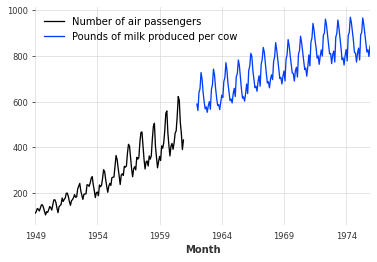

In [4]:
df_air = pd.read_csv('AirPassengers.csv', delimiter=',')
series_air = TimeSeries.from_dataframe(df_air, 'Month', ['#Passengers'])

df_milk = pd.read_csv('monthly-milk.csv', delimiter=',')
series_milk = TimeSeries.from_dataframe(df_milk, 'Month', ['Pounds per cow'])

series_air.plot(label='Number of air passengers')
series_milk.plot(label='Pounds of milk produced per cow')
plt.legend();

### Preprocessing
Usually neural networks tend to work better on normalised/standardised data. Here we'll use the `Scaler` class to normalise both of our time series between 0 and 1:

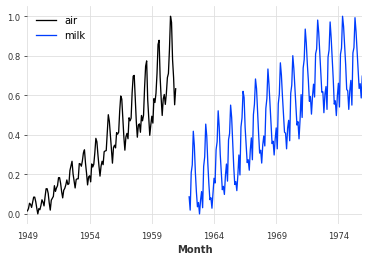

In [5]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label='air')
series_milk_scaled.plot(label='milk')
plt.legend();

### Train / Validation split
Let's keep the last 3 years of both series as validation:

In [13]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

## Global Forecasting Models
Darts contains many forecasting models, but not all of them can be trained on several time series. The models that support training on multiple series are called *global* models. At the time of writing, there are 4 global models:
* RNNs
* Temporal Convolutional Networks (TCNs)
* N-Beats
* Transformer model

In addition, all of these models (except N-Beats) also have multivariate support - i.e., they can seamlessly be used with time series of more than one dimension.

Internally, these models use neural networks that take chunks of time series in input, and output chunks of (predicted) future time series values:
![](static/images/global_io.png)

As user, this means there are 4 important parameters that have to be specified:
* `input_chunk_length`: this is the length of the lookback window; so each output will be computed based on the previous `input_chunk_length` points.
* `output_chunk_length`: this is the length of the outputs (forecasts) produced by the internal model. Often however, the `predict()` method of the "outer" Darts model can be called for a longer time horizon (this works only when no covariates are used). If `predict()` is called for a horizon longer than `output_chunk_length`, the internal model will simply be fed its own outputs in an auto-regressive fashion.
* `input_size` and `output_size`: these are the dimensionality (widths) of the input and output series. The `output_size` is always equal to the width of the target series (the series we are interested in predicting), whereas the `input_size` might be larger when covariates are used in inputs. We'll give more informations on covariates later on.

### Example

Let's look at a first example. We'll build a RNN that has a lookback window of 24 points (`input_chunk_length=24`) and predicts the next 12 points (`output_chunk_length=12`). Since our time series have 1 dimension, we'll set `input_size` and `output_size` to 1.

In [16]:
model_air = RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=300)

This model is a regular Darts forecasting model, and it can be fit on a single time series as follows:

In [17]:
model_air.fit(train_air, verbose=True)

[2021-01-14 16:49:21,810] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2021-01-14 16:49:21,810] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.


Training loss: 0.0043


We can then get a forecast by calling `predict()`. Note that below, we are calling `predict()` with a horizon of 36, which is longer than the model internal `output_chunk_length` of 12. That's not a problem here - in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

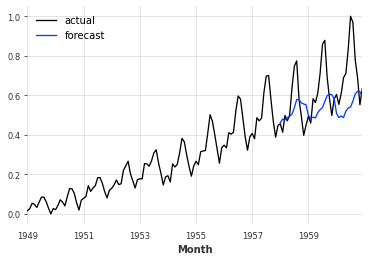

In [18]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();

### Training Process (behind the scenes)
So what happened when we called `model_air.fit()` above?

In order to train the internal neural network, Darts first makes a dataset of inputs/outputs examples from the provided time series (in this case: `series_air_scaled`). There are several ways this can be done; and Darts contains a few different dataset implementations in the `darts.utils.data` package. 

By default, most models will instantiate a `darts.utils.data.SequentialDataset`, which simply builds all the consecutive pairs of consecutive input/output sub-sequences (of lengths `input_chunk_length` and `output_chunk_length`) existing in the series, as follows:

![](static/images/seq_dataset_one_ts.png)

In the case of such a `SequentialDataset`, a series of length `N` would result in a "training set" of `N - input_chunk_length - output_chunk_length + 1` samples. In the toy example above, we have `N=14`, `input_chunk_length=4` and `output_chunk_length=2`, so the number of samples used for training would be K = 9. In this context, a training *epoch* consists in complete pass (possibly consisting of several mini-batches) over all these samples.

Note that different models are susceptible to use different datasets by default. For instance, `darts.utils.data.HorizonBasedDataset` produces samples that are "close" to the end of the series; emitting sample windows ranging/looking back from the end of the time series back to some multiple fractions of the horizon (`output_chunk_length`)

If you have the need to control the way training samples are produced from `TimeSeries` instances, you can implement your own training dataset by inheriting the abstract `darts.utils.data.TrainingDataset` class. Darts datasets are inheriting from Python `Sequence`, which means that you can also implement lazy versions that do not load all data in memory at once. Once you have your own instance of a dataset, you can directly call the `fit_from_dataset()` method on Darts models supporting this.

## Training a Model on Multiple Time Series
All this machinery can be seamlessly used with multiple time series. Here's how a `SequentialDataset` looks for two series:

![](static/images/seq_dataset_multi_ts.png)

Note a few things here:
* The different series do not need to have the same length, or even to share the same time stamps.
* In fact, they don't even need to have the same frequency
* The total number of samples in the training dataset (`K + H` in the example) will be the union of all the training samples contained in each series; so a training epoch will now span all samples from all series.


### Training on Both Air Traffic and Milk Series
Let's look at another example where we fit another model instance on our two time series (air passengers and milk production).

As both time series have a dimension of 1, we will keep `input_size=1` and `output_size=1`. Since using two series of (roughly) the same length roughly doubles the training dataset size, we will use half of the number of epochs:

In [19]:
model_air_milk = RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=150)

Then, fitting the model on two (or more) series is as simple as giving a list of series (instead of a single series) in argument to the `fit()` function:

In [20]:
model_air_milk.fit([train_air, train_milk], verbose=True)

[2021-01-14 16:50:29,145] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.
[2021-01-14 16:50:29,145] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.


Training loss: 0.0030


### Producing Forecasts After the End of a Series

Now, importantly, when computing the forecasts we have to specify which time series we want to predict the future for.

We didn't have this constraint earlier - when fitting models on one series only, Darts remembers this series internally, and if `predict()` is called without the `series` argument, it returns a forecast for the (unique) training series. This does not work anymore as soon as a model is fit on more than one series - in this case the `series` argument of `predict()` becomes mandatory.

So, let's say we want to predict future of air traffic. In this case we specify `series=train_air` to the `predict()` function in order to say we want to get a forecast for what comes after the train set of the air traffic:

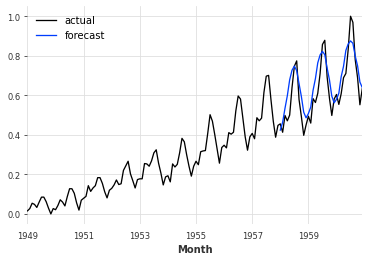

In [21]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();

Similarly, we could forecast the future values of any other series (even series never seen during training). Let's say we want to predict the future milk production:

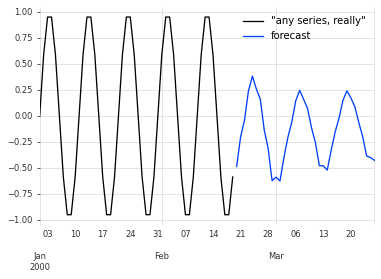

In [27]:
any_series = sine_timeseries(length=50)
pred = model_air_milk.predict(n=36, series=any_series)

any_series.plot(label='"any series, really"')
pred.plot(label='forecast')
plt.legend();

And similarly, we can of course use our model to predict the future of milk production:

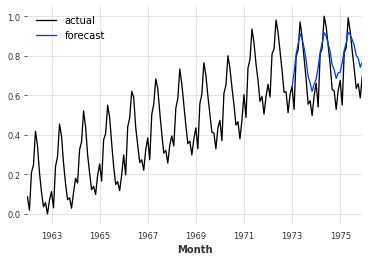

In [28]:
pred = model_air_milk.predict(n=36, series=train_milk)

series_milk_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();

Similar to what is supported by the `fit()` function, we can also give a list of series in argument to the `predict()` function, in which case it will return a list of forecast series:

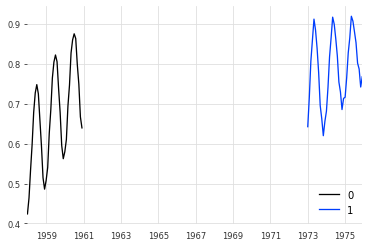

In [29]:
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for i, series in enumerate(pred_list):
    series.plot(label=str(i))
plt.legend();

The two series returned correspond to the forecasts after then end of `train_air` and `train_milk`, respectively.

## So: Does Milk Production Help Predict Air Traffic?
Let's look at this important question below. We will build 3 identical models, but fit them differently:
* one model will be fit on the air traffic series alone
* another will be fit on the mlik series alone
* the third will be fit on both series (with half the number of epochs).

In [31]:
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

# build models
model_air_alone = RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=400)
model_milk_alone = RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=400)
model_air_milk = RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=200)

# fit models
model_air_alone.fit(train_air)
model_milk_alone.fit(train_milk)
model_air_milk.fit([train_air, train_milk])

[2021-01-14 16:52:41,820] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2021-01-14 16:52:41,820] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2021-01-14 16:52:48,459] INFO | darts.models.torch_forecasting_model | Train dataset contains 97 samples.
[2021-01-14 16:52:48,459] INFO | darts.models.torch_forecasting_model | Train dataset contains 97 samples.
[2021-01-14 16:52:55,928] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.
[2021-01-14 16:52:55,928] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.


In [32]:
pred_from_air_model = model_air_alone.predict(n=len(val_air))
pred_from_milk_model = model_milk_alone.predict(n=len(val_air), series=train_air)
pred_from_air_milk_model = model_air_milk.predict(n=len(val_air), series=train_air)

print('Error predicting air traffic when training on air passengers alone: {:.2f}%'.format(mape(pred_from_air_model, val_air)))
print('Error predicting air traffic when training on milk production alone: {:.2f}%'.format(mape(pred_from_milk_model, val_air)))
print('Error predicting air traffic when training on both: {:.2f}%'.format(mape(pred_from_air_milk_model, val_air)))

Error predicting air traffic when training on air passengers alone: 26.87%
Error predicting air traffic when training on milk production alone: 8.93%
Error predicting air traffic when training on both: 10.06%


I let you draw your own conclusions :)

## Covariates Series

Until now, we have only been playing with models that only use the history of the *target* series to predict its future (here, by "target" we denote the time series whose future evolution we want to capture). However the global Darts models also support the use of *covariates* time series. These are time series of "external data", which we are not necessarily interested in predicting, but which we would still like to feed as input of our models because they can contain valuable information.

#### Building Covariates
Let's see a simple example with our air and milk series, where we'll try to use the year and month-of-the-year as covariates:

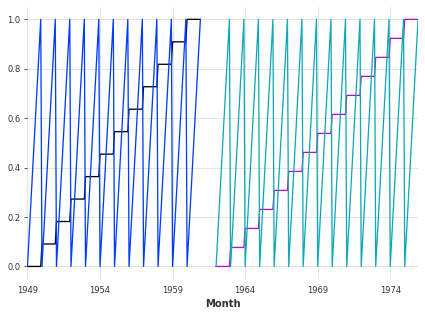

In [39]:
# build year and month series:
air_year = datetime_attribute_timeseries(series_air_scaled, attribute='year')
air_month = datetime_attribute_timeseries(series_air_scaled, attribute='month')

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute='year')
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute='month')

# stack year and month to obtain series of 2 dimensions (year and month):
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# scale them between 0 and 1:
scaler_dt_air = Scaler()
air_covariates = scaler_dt_air.fit_transform(air_covariates)

scaler_dt_milk = Scaler()
milk_covariates = scaler_dt_milk.fit_transform(milk_covariates)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = milk_covariates[:-36], milk_covariates[-36:]

# plot the covariates:
plt.figure(figsize=(7,5))
air_covariates.plot()
milk_covariates.plot()

Good, so each target series (air and milk), we have built a covariates series having the same time axis and containing the year and the month.

Note that here the covariates series are **multivariate time series**: they contain two dimensions - one dimension for the year and one for the month.

### Training with Covariates
When we want to use covariates, this increases the dimensionality (width) of the input series. The `input_size` has to capture now the sum of the width of the target series and the covariates:

![](static/images/global_io_covs.png)

So in our case, we have to specify an `input_size` of 3, because the target series has 1 dimension and the covariates has 2 dimensions:

In [40]:
model_cov = RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=200)

Now, to train the model with covariates, it is as simple as providing the covariates (in form of a list matching the target series) as `covariates` argument to the `fit()` function:

In [41]:
model_cov.fit(series=[train_air, train_milk], 
              covariates=[air_train_covariates, milk_train_covariates], 
              verbose=True)

[2021-01-14 19:59:06,737] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.
[2021-01-14 19:59:06,737] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.


Training loss: 0.0026


### Forecasting with Covariates
similarly, getting a forecast is now only a matter of specifying the `covariates` argument to the `predict()` function.

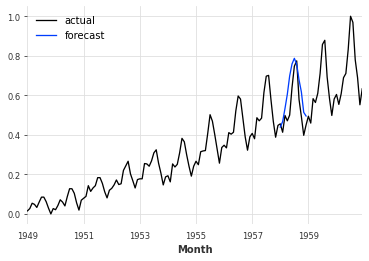

In [42]:
pred_cov = model_cov.predict(n=12, 
                             series=train_air, 
                             covariates=air_train_covariates)

series_air_scaled.plot(label='actual')
pred_cov.plot(label='forecast')
plt.legend();

The main catch above is that we cannot directly call `predict()` with a horizon `n` larger than the `output_chunk_length` we trained our model with. This is because when covariates are used, we cannot use the auto-regressive "trick" where we call the model iteratively on its own output, because in this case we do not have the corresponding covariates.

### Backtesting with Covariates
We can still backtest the model using covariates. Say for instance we are interested in evaluating the running accuracy with a horizon of 12 months, starting at 75% of the air series:


MAPE = 10.90%


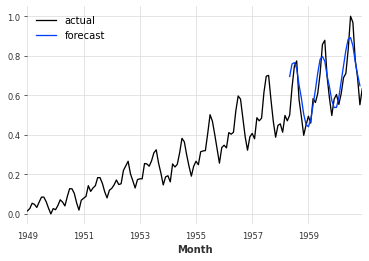

In [43]:
backtest_cov = model_cov.historical_forecasts(series_air_scaled,
                                              covariates=air_covariates,
                                              start=0.75,
                                              forecast_horizon=6,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_air_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_air_scaled, backtest_cov)))

Is it better than the model that we fit on the two series but without covariates? Let's see:


MAPE = 9.38%


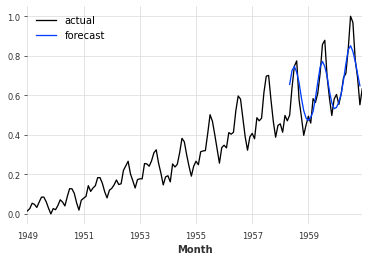

In [44]:
backtest_no_cov = model_air_milk.historical_forecasts(series_air_scaled,
                                              start=0.75,
                                              forecast_horizon=6,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_air_scaled.plot(label='actual')
backtest_no_cov.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_air_scaled, backtest_no_cov)))

### Future Covariates and Other Conditioning

At the moment Darts supports covariates that are themselves time series. Furthermore, these time must share the same time axes as the target series. The only real difference is that these covariates series will only be used as inputs of the model and not as outputs. 

However, even though the covariates and targets are required to share their time axis, the covariates can still represent known future values. For instance, if the target is influenced by some external factor (such as, say, the weather) and the weather is known 7 days in advance, then the covariates series can simply be built so that its value at time T represents the "week ahead" forecast for T+7 (this can typically be done by shifting the original series).

At the time of writing, Darts does not support covariates that are not time series - such as for instance class label informations or other conditioning variables. One trivial (although likely suboptimal) way to go around this is to build time series filled with constant values encoding the class labels.

## More examples with other models
TODO